In [1]:
#required libraries
!pip install diffusers==0.24.0 \
             transformers==4.37.2 \
             accelerate==0.26.1 \
             peft==0.8.2 \
             datasets==2.16.1 \
             huggingface_hub==0.19.4 \
             xformers==0.0.25 \
             ftfy --quiet


In [2]:
!pip install transformers torchvision ftfy
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y92lxqhk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y92lxqhk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install matplotlib

In [4]:
import os
import json
import shutil

# Output paths
output_img_dir = "anime_dataset/images"
output_caption_file = "anime_dataset/captions.txt"
os.makedirs(output_img_dir, exist_ok=True)

# Metadata and image folder pairs
metadata_files = [
    ("metadata_90.json", "90s Styled Anime Images"),
    ("metadata_random.json", "Randomly Styled Anime Images")
]

# Process and merge everything
with open(output_caption_file, "w", encoding="utf-8") as caption_file:
    for metadata_path, image_folder in metadata_files:
        with open(metadata_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)

            for item in metadata:
                rel_path = item["filename"]
                caption = item["prompt"]

                src_path = os.path.join(image_folder, rel_path)
                dst_name = os.path.basename(rel_path)
                dst_path = os.path.join(output_img_dir, dst_name)

                shutil.copyfile(src_path, dst_path)
                caption_file.write(caption.strip() + "\n")


In [5]:
print("Total images:", len(os.listdir("anime_dataset/images")))
print("Total captions:", sum(1 for _ in open("anime_dataset/captions.txt", "r", encoding="utf-8")))


Total images: 2000
Total captions: 3980


In [6]:
# Trim captions.txt to match image count
caption_path = "anime_dataset/captions.txt"
image_count = len(os.listdir("anime_dataset/images"))

with open(caption_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Keep only as many lines as images
with open(caption_path, "w", encoding="utf-8") as f:
    f.writelines(lines[:image_count])

print(f"Trimmed captions.txt to {image_count} lines")


Trimmed captions.txt to 2000 lines


In [7]:
from PIL import Image
from torch.utils.data import Dataset
import torch

# Custom PyTorch dataset to load anime-style images and their text captions
class AnimeCaptionDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform=None, tokenizer=None):
        self.image_dir = image_dir                  # Directory containing image files
        self.transform = transform                  # Transform to apply to images (e.g., resize, normalize)
        self.tokenizer = tokenizer                  # Tokenizer to convert text captions into token IDs

        # Load all captions from the provided text file
        with open(caption_file, "r", encoding="utf-8") as f:
            self.captions = [line.strip() for line in f]

        # Get a sorted list of image file names to match the captions
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.captions)

    def __getitem__(self, idx):
        # Load the image at the specified index
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB").resize((512, 512))  # Resize to 512x512 (required by SD)

        # Apply any image transformations (e.g., normalization)
        if self.transform:
            image = self.transform(image)

        # Get the corresponding caption for the image
        caption = self.captions[idx]

        # Tokenize the caption using CLIP tokenizer
        text_inputs = self.tokenizer(
            caption,
            padding="max_length",    # Pad to max length (77 tokens for CLIP)
            max_length=77,           # Maximum token length for CLIP
            truncation=True,         # Truncate if the caption is too long
            return_tensors="pt"      # Return as PyTorch tensors
        )

        # Return a dictionary containing the image and tokenized caption
        return {
            "pixel_values": image,                             # Transformed image tensor
            "input_ids": text_inputs["input_ids"].squeeze()    # Tokenized text (squeezed to remove extra dim)
        }


In [8]:
from transformers import CLIPTokenizer

# Load the CLIP tokenizer used by Stable Diffusion v1.5
# This tokenizer converts text prompts into token IDs that can be processed by the CLIP text encoder

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Image transform (resize, normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),             # [0, 1]
    transforms.Normalize([0.5], [0.5]) # → [-1, 1]
])

# Load dataset
dataset = AnimeCaptionDataset(
    image_dir="anime_dataset/images",
    caption_file="anime_dataset/captions.txt",
    transform=transform,
    tokenizer=tokenizer
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [10]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
from accelerate import Accelerator

# Initialize Accelerator for mixed-precision training
accelerator = Accelerator(mixed_precision="fp16")

# Load Stable Diffusion v1.5
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Apply LoRA to UNet
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
pipe.unet = get_peft_model(pipe.unet, lora_config)

# Filter trainable LoRA parameters
lora_params = [p for p in pipe.unet.parameters() if p.requires_grad]
print(f"Trainable LoRA Params: {sum(p.numel() for p in lora_params)}")


/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Trainable LoRA Params: 797184


In [11]:
unet = pipe.unet
vae = pipe.vae
text_encoder = pipe.text_encoder
optimizer = optim.AdamW(lora_params, lr=1e-5)

# Prepare with Accelerator
unet, vae, text_encoder, optimizer, dataloader = accelerator.prepare(
    unet, vae, text_encoder, optimizer, dataloader
)

# Training loop
num_epochs = 3
accumulation_steps = 2
global_step = 0

for epoch in range(num_epochs):
    unet.train()
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress_bar:
        try:
            pixel_values = batch["pixel_values"].to(dtype=torch.float16)
            input_ids = batch["input_ids"]

            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(input_ids)[0]

            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, pipe.scheduler.config.num_train_timesteps, (latents.shape[0],),
                device=latents.device
            ).long()

            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

            with accelerator.autocast():
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise) / accumulation_steps

            accelerator.backward(loss)
            accelerator.clip_grad_norm_(lora_params, max_norm=1.0)

            global_step += 1
            if global_step % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({"loss": loss.item() * accumulation_steps})
        except:
            continue

# Save LoRA weights
if accelerator.is_main_process:
    pipe.save_lora_weights("fine_tuned_lora_weights")

# Save full model (optional)
pipe.save_pretrained("fine_tuned_stable_diffusion")

# Cleanup
accelerator.free_memory()

Epoch 3/3: 100%|██████████| 500/500 [01:21<00:00,  6.15it/s]
self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    

In [12]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Load base pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Load fine-tuned LoRA weights
pipe.load_lora_weights("fine_tuned_lora_weights")

# Set to eval mode
pipe.unet.eval()


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [28]:
# Create directory to store generated images
os.makedirs("generated_images", exist_ok=True)

# Prompts for generation
prompts = [
    "a portrait of an anime girl with blue hair",
    "an anime boy in a futuristic cyberpunk setting",
    "a fantasy landscape in anime style with dragons and castles",
    "an elegant anime princess standing on a balcony under a moonlit sky",
    "a futuristic anime cityscape with neon lights and flying cars"
]

images = []

# Generate and save images
for i, prompt in enumerate(prompts):
    with torch.no_grad():
        result = pipe(prompt, num_inference_steps=30, guidance_scale=7.5)
        if result.images and isinstance(result.images[0], Image.Image):
            image = result.images[0]
            image_path = f"generated_images/image_{i}.png"
            image.save(image_path)
            images.append(image)

print(f"Generated and saved {len(images)} images.")


100%|██████████| 30/30 [00:00<00:00, 37.19it/s]


Generated and saved 5 images.


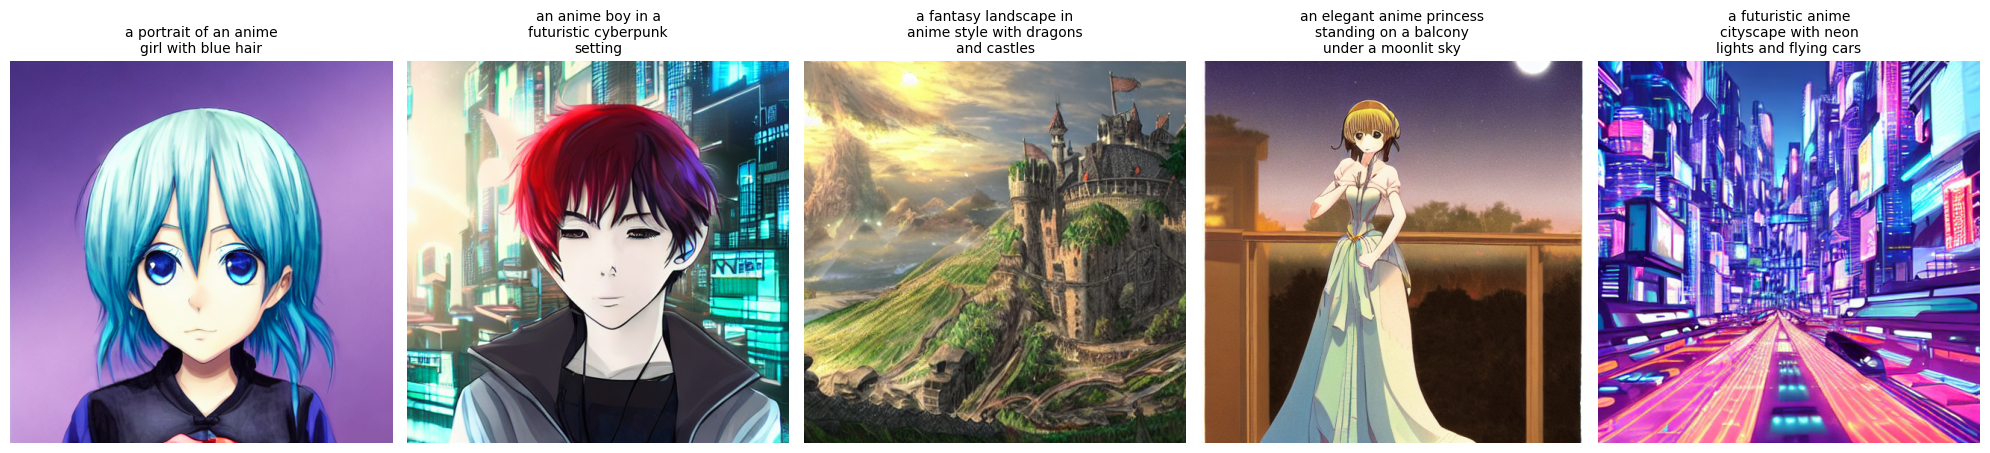

In [29]:
import textwrap
# Function to display generated images
def show_images(images, prompts, scores=None):
    n = len(images)
    plt.figure(figsize=(4 * n, 5))
    for i, img in enumerate(images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        caption = prompts[i]
        if scores:
            caption += f"\nCLIP Score: {scores[i]:.4f}"
        caption = "\n".join(textwrap.wrap(caption, width=25))
        plt.title(caption, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(images, prompts)

In [30]:
import clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Compute CLIP similarity
def get_clip_similarity(image, prompt):
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([prompt]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).item()
    return similarity

# Evaluate all generated images
for img, prompt in zip(images, prompts):
    score = get_clip_similarity(img, prompt)
    print(f"Prompt: {prompt}\nCLIP Similarity: {score:.4f}\n")


Prompt: a portrait of an anime girl with blue hair
CLIP Similarity: 0.3193

Prompt: an anime boy in a futuristic cyberpunk setting
CLIP Similarity: 0.3186

Prompt: a fantasy landscape in anime style with dragons and castles
CLIP Similarity: 0.3596

Prompt: an elegant anime princess standing on a balcony under a moonlit sky
CLIP Similarity: 0.3723

Prompt: a futuristic anime cityscape with neon lights and flying cars
CLIP Similarity: 0.3538



In [16]:
!pip install spicy 

In [31]:
from torchvision.models import inception_v3, Inception_V3_Weights
import numpy as np
from scipy.stats import entropy

# Load pretrained Inception V3 with proper weights (fixes deprecation warning)
weights = Inception_V3_Weights.IMAGENET1K_V1
inception_model = inception_v3(weights=weights).to(device)
inception_model.eval()

# Transform for Inception V3
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to calculate Inception Score
def get_inception_score(images):
    preds = []
    for img in images:
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.softmax(inception_model(img_tensor), dim=1)
        preds.append(pred.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    scores = []
    for p in preds:
        kl = p * (np.log(p + 1e-16) - np.log(np.mean(preds, axis=0) + 1e-16))
        scores.append(np.exp(np.sum(kl)))

    return np.mean(scores), np.std(scores)

# Call it with the `images` you already generated from your prompts
is_mean, is_std = get_inception_score(images)
print(f"Inception Score: Mean = {is_mean:.4f}, Std = {is_std:.4f}")


Inception Score: Mean = 3.1886, Std = 0.6913
